In [32]:
import numpy as np
import pandas as pd

# Prepare the quasar sample by calculating flux ratios
from class_photoz import ml_quasar_sample as qs
# Load the random forest regression functions
from class_photoz import rf_reg as rf
# Load the random forest classification functions
from class_photoz import rf_class as rf_class
# Load the Machine Learning analysis functions/plots
from class_photoz import ml_analysis as ml_an
# Load the Photometric Redshift analysis functions/plots
from class_photoz import photoz_analysis as pz_an


In [25]:
# --------------------------------------------------------------------------
# Preparing the feature matrix
# --------------------------------------------------------------------------
df_train = pd.read_hdf('../class_photoz/data/DR7DR12Q_clean_flux_cat_minimal.hdf5','data')

passband_names = [\
        'SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z', \
        # 'TMASS_j','TMASS_h','TMASS_k', \
        'WISE_w1','WISE_w2', \
        # 'WISE_w3' \
        ]

df_train.replace(np.inf, np.nan,inplace=True)
df_train.query('10 > Z_VI > 0.0 and SDSS_mag_i < 21.5',inplace=True)

df_train,features = qs.prepare_flux_ratio_catalog(df_train,passband_names)

# df_train = df_train.sample(frac=0.5)



Feature Importances 
SDSS_i: 0.0183222969636
WISE_w1: 0.0711177534712
ug: 0.324452971577
gr: 0.0721304211033
ri: 0.0560693884165
iz: 0.0408067007548
zw1: 0.377971618858
w1w2: 0.0391288488552


Explained Variance Score
[ 0.81591783]


Mean Absolute Error
[ 0.18226939]


Mean Squared Error
[ 0.13561474]
Standard deviation: 
0.368254455475
R 0.3 :  0.858401531151
R 0.2 :  0.767984424498
R 0.1 :  0.538575765576
Redshift normalized standard devation: 
0.16478814323
Photometric Redshift evaluation
Total number of test objects :  30304
Delta z < 0.3 :  0.954527455121
Delta z < 0.2 :  0.925950369588
Delta z < 0.1 :  0.836919218585


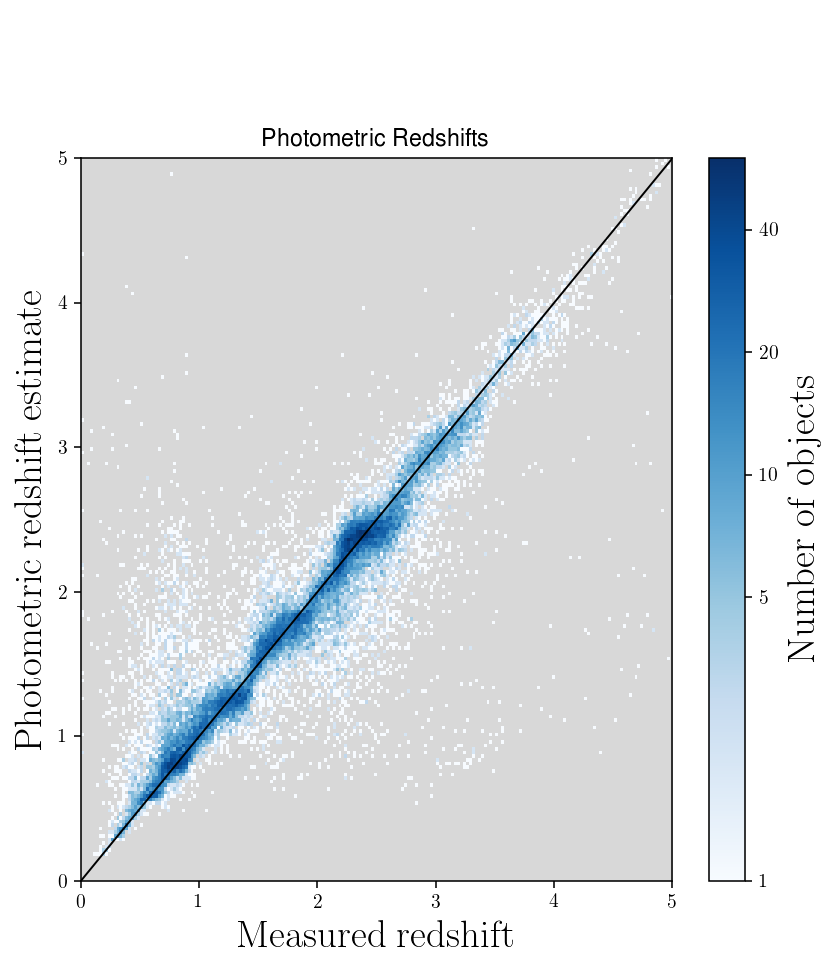

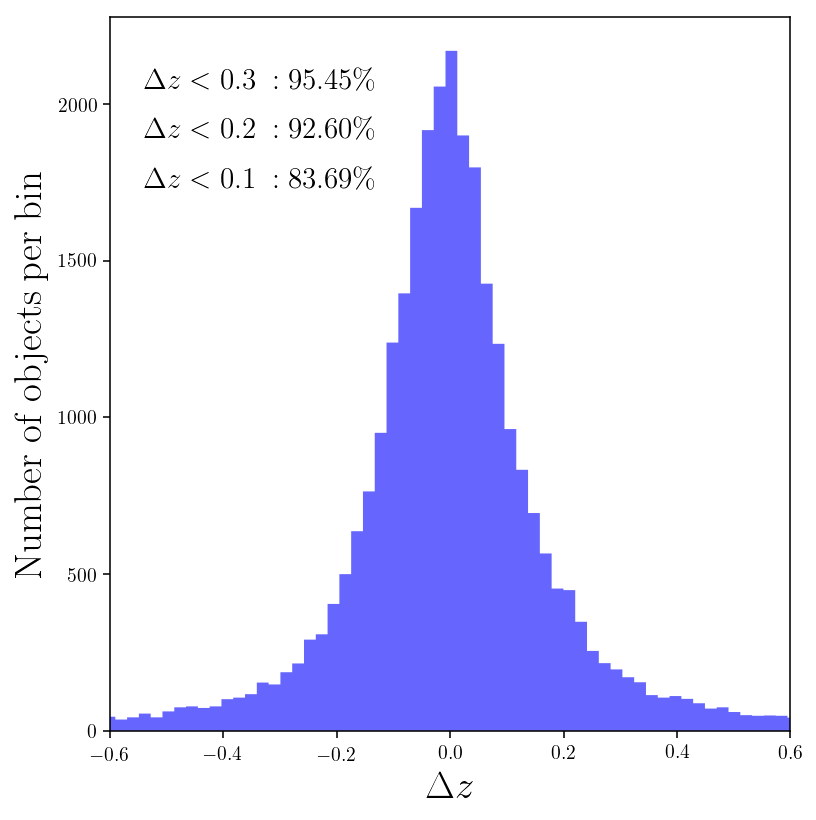

In [28]:
# --------------------------------------------------------------------------
# Random Forest Regression Grid Search
# --------------------------------------------------------------------------

features = ['SDSS_i','WISE_w1','ug','gr','ri','iz','zw1','w1w2']
# features = ['SDSS_i','WISE_w1','TMASS_j','ug','gr','ri','iz','zj','jh', 'hk', 'kw1', 'w1w2']
label = 'z'
rand_state = 1

params = {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 2, 'n_jobs': 2, 'random_state':rand_state,}


rf.rf_reg_example(df_train,features,label,params,rand_state,save=True,save_filename='test')

In [34]:
df_stars = pd.read_hdf('../class_photoz/data/DR13_stars_clean_flux_cat_minimal.hdf5', 'data')
df_quasars = pd.read_hdf('../class_photoz/data/DR7DR12Q_clean_flux_cat_minimal.hdf5', 'data')

passband_names = ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', \
                    # 'TMASS_j', \
                    # 'TMASS_h', \
                    # 'TMASS_k', \
                    'WISE_w1', \
                    'WISE_w2', \
                    # 'WISE_w3', \
                    # 'WISE_w4', \
                    ]

df_stars, features = \
    qs.prepare_flux_ratio_catalog(df_stars, passband_names)
df_quasars, features = \
    qs.prepare_flux_ratio_catalog(df_quasars, passband_names)


df_stars.query('SDSS_mag_i <= 21.5', inplace=True)
df_quasars.query('SDSS_mag_i <= 21.5', inplace=True)

print "Stars: ", df_stars.shape
print "Quasars: ", df_quasars.shape

# Create detailed classes
df_quasars = qs.create_qso_labels(df_quasars, 'mult_class_true', 'z')
df_stars = qs.create_star_labels(df_stars, 'mult_class_true', 'star_class')

# Create binary classes
df_quasars['bin_class_true'] = 'QSO'
df_stars['bin_class_true'] = 'STAR'


Stars:  (245070, 43)
Quasars:  (152503, 45)
Quasar classes with new labels: 

vlowz    56879
midz     53882
lowz     37248
highz     4397
Name: mult_class_true, dtype: int64
Stellar classes with new labels: 

F    99654
M    59557
K    47904
G    18487
A    16017
Name: mult_class_true, dtype: int64


Classification Report 
             precision    recall  f1-score   support

          A       0.86      0.67      0.75      3178
          F       0.82      0.92      0.86     19872
          G       0.63      0.31      0.41      3618
          K       0.91      0.89      0.90      9636
          M       0.98      0.99      0.98     12020
      highz       0.91      0.85      0.88       875
       lowz       0.85      0.82      0.84      7385
       midz       0.88      0.93      0.90     10751
      vlowz       0.92      0.92      0.92     11471

avg / total       0.87      0.88      0.87     78806



Feature Importance 
SDSS_i: 0.0532090886747
WISE_w1: 0.0496634279834
ug: 0.171776968282
gr: 0.171710466157
ri: 0.183695199435
iz: 0.0916743787464
zw1: 0.186341603416
w1w2: 0.0919288673056




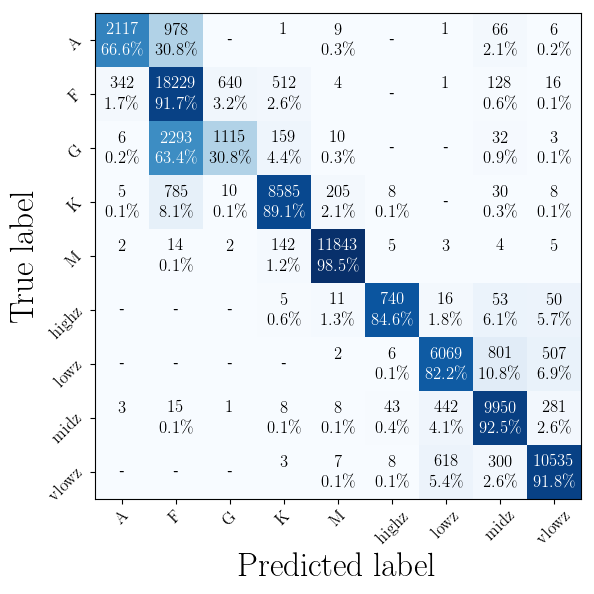

In [35]:
# Make test and training set
df_train, df_pred = qs.make_train_pred_set(df_stars, df_quasars, 0.2, rand_state = 1)


features = ['SDSS_i','WISE_w1','ug','gr','ri','iz','zw1','w1w2']

label = 'mult_class_true'

params = {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 3,
          'n_jobs': 2, 'random_state': 1}

rand_state = 1

y_true, y_pred, df_prob = rf_class.rf_class_example(df_train, df_pred,
                          features, label, params, rand_state)